# Load Libraries

In [157]:
import soccerdata as sd
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque 
import requests
from bs4 import BeautifulSoup

from sklearn.preprocessing import StandardScaler

# SoccerData Scraper

In [158]:
# Create a scraper class instance for  for the 2020/21 & 2021/22
mh = sd.MatchHistory(leagues=['GER-Bundesliga'], seasons=['2020-2021'])
mh2= sd.MatchHistory(leagues=['GER-Bundesliga'], seasons=['2021-2022'])
fbref1 = sd.FBref(leagues=['GER-Bundesliga'], seasons=['2020-2021'])
# Get match data of each team
match_stats= mh.read_games()
test_data = mh2.read_games()
additional_train = fbref1.read_team_match_stats()
additional_test = pd.read_csv('/Users/kevinwildprett/Desktop/Hochschule/5. Semester/Projektarbeit/Neuer Ordner/additional_train.csv', sep=';') ## !!!!!!

[03/12/25 14:18:21] INFO     Saving cached data to /Users/kevinwildprett/soccerdata/data/MatchHistory ]8;id=587118;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=288192;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py#89\89]8;;\

                    INFO     Saving cached data to /Users/kevinwildprett/soccerdata/data/MatchHistory ]8;id=280434;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=690305;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py#89\89]8;;\

                    INFO     Saving cached data to /Users/kevinwildprett/soccerdata/data/FBref        ]8;id=457665;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=135618;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py#89\89]8;;\

# Beautiful Soup Scraper

### Get team value for train data

In [159]:
url= 'https://www.transfermarkt.de/bundesliga/startseite/wettbewerb/L1/plus/?saison_id=2020'

page = requests.get(url)

# Header imitates browser request
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}

# HTTP-Request send
response = requests.get(url, headers=headers)

soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find(id= 'yw1')
teams = table.find_all('td', {'class': 'hauptlink no-border-links'})
all_teams = [team.text.replace('\xa0', ' ').strip() for team in teams]

#Ffind  <tbody> 
tbody = table.find('tbody')

# Find <td>-elements with class "rechts" in <tbody> 
if tbody:
    gesamtwert = tbody.find_all('td', {'class': 'rechts'})
all_values = [gesamtwert.text for i, gesamtwert in enumerate(gesamtwert) if i % 2 != 0]

df_teams = pd.DataFrame({
    'team': all_teams,
    'total_values': all_values
})

### Get team value for test data

In [160]:

url= 'https://www.transfermarkt.de/bundesliga/startseite/wettbewerb/L1/saison_id/2021'

page = requests.get(url)


headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}


response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find(id= 'yw1')
teams = table.find_all('td', {'class': 'hauptlink no-border-links'})
all_teams = [team.text.replace('\xa0', ' ').strip() for team in teams]


tbody = table.find('tbody')


if tbody:
    gesamtwert = tbody.find_all('td', {'class': 'rechts'})
all_values = [gesamtwert.text for i, gesamtwert in enumerate(gesamtwert) if i % 2 != 0]

df_teams2 = pd.DataFrame({
    'team': all_teams,
    'total_values': all_values
})

# Data Preperation

In [161]:
# Map the names to the ones in the main frame
team_mapping = {
    'FC Bayern München': 'Bayern Munich',
    'Borussia Dortmund': 'Dortmund',
    'RB Leipzig': 'RB Leipzig',
    'Bayer 04 Leverkusen': 'Leverkusen',
    'Borussia Mönchengladbach': "M\'gladbach",
    'Eintracht Frankfurt': 'Ein Frankfurt',
    'VfL Wolfsburg': 'Wolfsburg',
    'Hertha BSC': 'Hertha',
    'TSG 1899 Hoffenheim': 'Hoffenheim',
    'VfB Stuttgart': 'Stuttgart',
    '1.FSV Mainz 05': 'Mainz',
    'SC Freiburg': 'Freiburg',
    'FC Schalke 04': 'Schalke 04',
    '1.FC Köln': 'FC Koln',
    'SV Werder Bremen': 'Werder Bremen',
    'FC Augsburg': 'Augsburg',
    '1.FC Union Berlin': 'Union Berlin',
    'Arminia Bielefeld': 'Bielefeld',
    'SpVgg Greuther Fürth' : 'Greuther Furth',
    'VfL Bochum' : 'Bochum'
}


In [162]:
# Use mapping on team value dataframe
df_teams['team'] = df_teams['team'].replace(team_mapping)
df_teams2['team'] = df_teams2['team'].replace(team_mapping)

In [163]:
# Convert the 'total_values' column 
df_teams['total_values'] = df_teams['total_values'].str.replace(' Mio. €', '', regex=False).str.replace(',', '.').astype(float, errors='ignore')
df_teams2['total_values'] = df_teams2['total_values'].str.replace(' Mio. €', '', regex=False).str.replace(',', '.').astype(float, errors='ignore')


In [164]:
# Convert MultiIndex into regular one
match_stats = match_stats.reset_index()
match_stats.reset_index(drop=True, inplace=True)

test_data = test_data.reset_index()
test_data.reset_index(drop=True, inplace=True)


### Add team value to train data

In [165]:
# Merge for home_market_value
match_stats = pd.merge(match_stats,  df_teams[['team', 'total_values']], left_on='home_team', right_on='team').rename(columns={'total_values': 'home_value'})
match_stats = match_stats.drop(columns=['team'])

In [166]:
# Merge for away_market_value
match_stats = pd.merge(match_stats,  df_teams[['team', 'total_values']], left_on='away_team', right_on='team').rename(columns={'total_values': 'away_value'})
match_stats = match_stats.drop(columns=['team'])

### Add team value to test data

In [167]:
# Merge for home_market_value
test_data = pd.merge(test_data,  df_teams2[['team', 'total_values']], left_on='home_team', right_on='team').rename(columns={'total_values': 'home_value'})
test_data = test_data.drop(columns=['team'])

In [168]:
# Merge for away_market_value
test_data = pd.merge(test_data,  df_teams2[['team', 'total_values']], left_on='away_team', right_on='team').rename(columns={'total_values': 'away_value'})
test_data = test_data.drop(columns=['team'])

In [169]:
match_stats = match_stats.sort_values(by='date').reset_index(drop=True)
test_data = test_data.sort_values(by='date').reset_index(drop=True)

### Additional dataframe (Fbref) preperation

In [170]:
#Fill nan value with value above
additional_test['team'] = additional_test['team'].fillna(method='ffill')

# Fill the xGoals with 0
additional_test['xG'] = additional_test['xG'].fillna(0)
additional_test['xGA'] = additional_test['xGA'].fillna(0)

additional_train['xG'] = additional_train['xG'].fillna(0)
additional_train['xGA'] = additional_train['xGA'].fillna(0)

additional_test['xG'] = additional_test['xG'].str.replace(',', '.', regex=False)
additional_test['xGA'] = additional_test['xGA'].str.replace(',', '.', regex=False)



In [171]:
# Convert MultiIndex into regular one
additional_test = additional_test.reset_index()
additional_test.reset_index(drop=False, inplace=True)

additional_train = additional_train.reset_index()
additional_train.reset_index(drop=False, inplace=True)

In [172]:
# Clean up additional data for merging
additional_train = additional_train.sort_values(by='date')
additional_test = additional_test.sort_values(by='date')
# Keep olny matchdays rows
additional_train = additional_train[additional_train['round'].str.startswith('Matchweek', na=False)]
additional_test = additional_test[additional_test['round'].str.startswith('Matchweek', na=False)]

In [173]:
# Map the additional dataframe onto the main ones
team_mapping = {
    'Arminia': 'Bielefeld',
    'Augsburg': 'Augsburg',
    'Bayern Munich': 'Bayern Munich',
    'Dortmund': 'Dortmund',
    'Eint Frankfurt': 'Ein Frankfurt',
    'Freiburg': 'Freiburg',
    'Gladbach': "M\'gladbach",
    'Hertha BSC': 'Hertha',
    'Hoffenheim': 'Hoffenheim',
    'Köln': 'FC Koln',
    'Leverkusen': 'Leverkusen',
    'Mainz 05': 'Mainz',
    'RB Leipzig': 'RB Leipzig',
    'Schalke 04': 'Schalke 04',
    'Stuttgart': 'Stuttgart',
    'Union Berlin': 'Union Berlin',
    'Werder Bremen': 'Werder Bremen',
    'Wolfsburg': 'Wolfsburg',
    'Greuther Fürth': 'Greuther Furth' 
    
}

In [174]:
columns_to_replace = ['team', 'opponent']

# Use mapping
additional_train[columns_to_replace] = additional_train[columns_to_replace].replace(team_mapping)
additional_test[columns_to_replace] = additional_test[columns_to_replace].replace(team_mapping)

### Merge expected goals to train dataset 

In [175]:
# For home_team column
match_stats = pd.merge(
    match_stats,
    additional_train[['team', 'opponent', 'xG']],
    left_on=['home_team', 'away_team'],
    right_on=['team', 'opponent'],
    how='left'
   
)
match_stats = match_stats.drop(columns=['team', 'opponent'])

In [176]:
match_stats = match_stats.drop_duplicates(subset=['home_team', 'away_team'])
#print(match_stats.duplicated(subset=['home_team', 'away_team']).sum())

In [177]:
#For away_team

match_stats = pd.merge(
    match_stats,
    additional_train[['team', 'opponent', 'xGA']],
    left_on=['home_team', 'away_team'],  
    right_on=['team', 'opponent'],      
    how='left'
)
match_stats = match_stats.drop(columns=['team', 'opponent'])

In [178]:
match_stats = match_stats.drop_duplicates(subset=['home_team', 'away_team'])
#print(match_stats.duplicated(subset=['home_team', 'away_team']).sum())

In [179]:
#match_stats.columns.values

### Merge expected goals to test data 

In [180]:
#For home_team
test_data = pd.merge(
    test_data,
    additional_test[['team', 'opponent', 'xG']],
    left_on=['home_team', 'away_team'],
    right_on=['team', 'opponent'],
    how='left'
)

test_data = test_data.drop(columns=['team', 'opponent'])

In [181]:
#For away_team

test_data = pd.merge(
    test_data,
    additional_test[['team', 'opponent', 'xGA']],
    left_on=['home_team', 'away_team'],  
    right_on=['team', 'opponent'],      
    how='left'
)
test_data = test_data.drop(columns=['team', 'opponent'])

In [182]:
test_data = test_data.drop_duplicates(subset=['home_team', 'away_team'])
#print(test_data.duplicated(subset=['home_team', 'away_team']).sum())

In [183]:
#test_data.columns.values

# Feature-Engineering

Matchdays (possitive impact)

In [184]:
# Function to calculate matchdays for each team
def update_matchday(row,team_matchday_counts):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Increment matchday count for home and away teams
    team_matchday_counts[home_team] += 1
    team_matchday_counts[away_team] += 1
    
    # Assign matchday counts to the row
    row['home_team_matchday'] = team_matchday_counts[home_team]
    row['away_team_matchday'] = team_matchday_counts[away_team]
    
    return row
# Apply the function to the first DataFrame with a separate dictionary
team_matchday_counts_df1 = defaultdict(int)
match_stats = match_stats.apply(lambda row: update_matchday(row, team_matchday_counts_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_matchday_counts_df2 = defaultdict(int)
test_data = test_data.apply(lambda row: update_matchday(row, team_matchday_counts_df2), axis=1)

Cumulative Points (possitive impact)

In [185]:
# Function to update cumulative points for each team
def update_cumulative_points(row, team_points):
    home_team = row['home_team']
    away_team = row['away_team']
    home_matchday = row['home_team_matchday']
    away_matchday = row['away_team_matchday']
    
    # Initialize cumulative points as 0 for the first matchday
    if home_matchday == 1:
        row['home_cumulative_points'] = 0
    else:
        row['home_cumulative_points'] = team_points[home_team]
    
    if away_matchday == 1:
        row['away_cumulative_points'] = 0
    else:
        row['away_cumulative_points'] = team_points[away_team]
    
    # Update points based on match result (add to history after setting current cumulative points)
    if row['FTR'] == 'H':  # Home team wins
        team_points[home_team] += 3  # 3 points for home team
        team_points[away_team] += 0  # 0 points for away team
    elif row['FTR'] == 'A':  # Away team wins
        team_points[home_team] += 0  # 0 points for home team
        team_points[away_team] += 3  # 3 points for away team
    else:  # Draw
        team_points[home_team] += 1  # 1 point for home team
        team_points[away_team] += 1  # 1 point for away team
    
    return row

In [186]:
# Apply the function to the first DataFrame with a separate dictionary
team_points_df1 = defaultdict(int)
match_stats = match_stats.apply(lambda row: update_cumulative_points(row, team_points_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_points_df2 = defaultdict(int)
test_data = test_data.apply(lambda row: update_cumulative_points(row, team_points_df2), axis=1)

Wins in last 5 matchdays (negative impact)

In [187]:
# Function to update the last 5 match history and count wins
def update_last_5_wins(row, team_last_5_results):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Calculate the number of wins in the last 5 matches or fewer if not enough matches have been played
    row['home_last_5_wins'] = sum(team_last_5_results[home_team])
    row['away_last_5_wins'] = sum(team_last_5_results[away_team])
    
    # Add current match result to history (after calculation)
    if row['FTR'] == 'H':  # Home team wins
        team_last_5_results[home_team].append(1)
        team_last_5_results[away_team].append(0)
    elif row['FTR'] == 'A':  # Away team wins
        team_last_5_results[home_team].append(0)
        team_last_5_results[away_team].append(1)
    else:  # Draw
        team_last_5_results[home_team].append(0)
        team_last_5_results[away_team].append(0)
    
    return row



In [188]:
# Apply the function to the first DataFrame with a separate dictionary
team_last_5_results_df1 = defaultdict(lambda: deque(maxlen=5))
match_stats = match_stats.apply(lambda row: update_last_5_wins(row, team_last_5_results_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_last_5_results_df2 = defaultdict(lambda: deque(maxlen=5))
test_data = test_data.apply(lambda row: update_last_5_wins(row, team_last_5_results_df2), axis=1)

Shots on Goal (negative impact)

In [189]:
# Function to update the number of shots on target for each team in the last 5 matches
def update_last_5_shots(row, team_last_5_shots):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Calculate the total shots on target in the last 5 matches or fewer if not enough matches have been played
    row['home_last_5_shots'] = sum(team_last_5_shots[home_team])
    row['away_last_5_shots'] = sum(team_last_5_shots[away_team])
    
    # Add current match shots on target to history
    team_last_5_shots[home_team].append(row['HST'])  # Home shots on target
    team_last_5_shots[away_team].append(row['AST'])  # Away shots on target
    
    return row

In [190]:
# Apply the function to the first DataFrame with a separate dictionary
team_last_5_shots_df1 = defaultdict(lambda: deque(maxlen=5))
match_stats = match_stats.apply(lambda row: update_last_5_shots(row, team_last_5_shots_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_last_5_shots_df2 = defaultdict(lambda: deque(maxlen=5))
test_data = test_data.apply(lambda row: update_last_5_shots(row, team_last_5_shots_df2), axis=1)

Goaldifference (possitive impact)

In [191]:
# Function to update the goal difference for each team in the last 5 matches
def update_last_5_goal_diff(row, team_last_5_goal_diff):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Calculate the current match goal difference
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = -home_goal_diff  # Invert for the away team

    # Calculate the total goal difference in the last 5 matches or fewer if not enough matches have been played
    row['home_last_5_goal_diff'] = sum(team_last_5_goal_diff[home_team])
    row['away_last_5_goal_diff'] = sum(team_last_5_goal_diff[away_team])
    
    # Add current match goal difference to history
    team_last_5_goal_diff[home_team].append(home_goal_diff)
    team_last_5_goal_diff[away_team].append(away_goal_diff)
    
    return row

In [192]:
# Apply the function to the first DataFrame with a separate dictionary
team_last_5_goal_diff_df1 = defaultdict(lambda: deque(maxlen=5))
match_stats = match_stats.apply(lambda row: update_last_5_goal_diff(row, team_last_5_goal_diff_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_last_5_goal_diff_df2 = defaultdict(lambda: deque(maxlen=5))
test_data = test_data.apply(lambda row: update_last_5_goal_diff(row, team_last_5_goal_diff_df2), axis=1)

Amount halftime goals (possitive impact)

In [193]:
# Function to calculate and update the sum of half-time goals for the last 5 matches for each team
def calculate_last_5_half_time_goals(row, team_last_5_half_time_goals):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Calculate the sum of half-time goals in the last 5 matches or fewer if not enough matches have been played
    row['home_last_5_half_time_goals'] = sum(team_last_5_half_time_goals[home_team])
    row['away_last_5_half_time_goals'] = sum(team_last_5_half_time_goals[away_team])
    
    # Add the current match half-time goals to history
    team_last_5_half_time_goals[home_team].append(row['HTHG'])  # Home half-time goals
    team_last_5_half_time_goals[away_team].append(row['HTAG'])  # Away half-time goals
    
    return row

In [194]:
# Apply the function to the first DataFrame with a separate dictionary
team_last_5_half_time_goals_df1 = defaultdict(lambda: deque(maxlen=5))
match_stats = match_stats.apply(lambda row: calculate_last_5_half_time_goals(row, team_last_5_half_time_goals_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_last_5_half_time_goals_df2 = defaultdict(lambda: deque(maxlen=5))
test_data = test_data.apply(lambda row: calculate_last_5_half_time_goals(row, team_last_5_half_time_goals_df2), axis=1)


Corner shots (possitive impact)

In [195]:
# Function to calculate and update the sum of shot corners for the last 5 matches for each team
def calculate_last_5_corners_shot(row, team_last_5_corners_shot):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Calculate the sum of Corners in the last 5 matches or fewer if not enough matches have been played
    row['home_last_5_half_corners_shot'] = sum(team_last_5_corners_shot[home_team])
    row['away_last_5_half_corners_shot'] = sum(team_last_5_corners_shot[away_team])
    
    # Add the current match corners to history
    team_last_5_corners_shot[home_team].append(row['HC'])  # Home Corners
    team_last_5_corners_shot[away_team].append(row['AC'])  # Away Corners
    
    return row


In [196]:
# Apply the function to the first DataFrame with a separate dictionary
team_last_5_corners_shot_df1 = defaultdict(lambda: deque(maxlen=5))
match_stats = match_stats.apply(lambda row: calculate_last_5_corners_shot(row, team_last_5_corners_shot_df1), axis=1)

# Apply the function to the second DataFrame with a new dictionary
team_last_5_corners_shot_df2 = defaultdict(lambda: deque(maxlen=5))
test_data = test_data.apply(lambda row: calculate_last_5_corners_shot(row, team_last_5_corners_shot_df2), axis=1)

ELO-Ratings (possitive impact)

In [197]:
# Dictionary to keep track of current Elo ratings for each team
# Reset Elo ratings and ensure initial value is 1500 for all teams
# Re-initialize Elo calculation to ensure correct data
team_elo = defaultdict(lambda: 1500)
K=32

# Lists to store Elo ratings for current matchdays
current_home_elo_list = []
current_away_elo_list = []

# Iterate over each match to calculate Elo ratings correctly
for index, row in match_stats.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    # Get the current Elo ratings from the dictionary
    current_home_elo = team_elo[home_team]
    current_away_elo = team_elo[away_team]

    # Append the current Elo ratings to the lists
    current_home_elo_list.append(current_home_elo)
    current_away_elo_list.append(current_away_elo)

    # Calculate expected outcomes
    expected_home = 1 / (1 + 10 ** ((current_away_elo - current_home_elo) / 400))
    expected_away = 1 / (1 + 10 ** ((current_home_elo - current_away_elo) / 400))

    # Determine actual match outcome
    if row['FTHG'] > row['FTAG']:  # Home win
        actual_home = 1
        actual_away = 0
    elif row['FTHG'] < row['FTAG']:  # Away win
        actual_home = 0
        actual_away = 1
    else:  # Draw
        actual_home = 0.5
        actual_away = 0.5

    # Update Elo ratings using the K factor
    new_home_elo = current_home_elo + K * (actual_home - expected_home)
    new_away_elo = current_away_elo + K * (actual_away - expected_away)

    # Update the dictionary with the new Elo ratings for the next match
    team_elo[home_team] = new_home_elo
    team_elo[away_team] = new_away_elo

# Add the current Elo ratings to the DataFrame
match_stats['current_home_elo'] = current_home_elo_list
match_stats['current_away_elo'] = current_away_elo_list

/var/folders/n_/wh82d8z12pjcn_v99zhyg1t80000gn/T/ipykernel_33704/750708775.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_stats['current_home_elo'] = current_home_elo_list
/var/folders/n_/wh82d8z12pjcn_v99zhyg1t80000gn/T/ipykernel_33704/750708775.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  match_stats['current_away_elo'] = current_away_elo_list


In [198]:
# 4 test data
# Dictionary to keep track of current Elo ratings for each team
# Reset Elo ratings and ensure initial value is 1500 for all teams
# Re-initialize Elo calculation to ensure correct data
team_elo = defaultdict(lambda: 1500)
K=32

# Lists to store Elo ratings for current matchdays
current_home_elo_list = []
current_away_elo_list = []

# Iterate over each match to calculate Elo ratings correctly
for index, row in test_data.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    # Get the current Elo ratings from the dictionary
    current_home_elo = team_elo[home_team]
    current_away_elo = team_elo[away_team]

    # Append the current Elo ratings to the lists
    current_home_elo_list.append(current_home_elo)
    current_away_elo_list.append(current_away_elo)

    # Calculate expected outcomes
    expected_home = 1 / (1 + 10 ** ((current_away_elo - current_home_elo) / 400))
    expected_away = 1 / (1 + 10 ** ((current_home_elo - current_away_elo) / 400))

    # Determine actual match outcome
    if row['FTHG'] > row['FTAG']:  # Home win
        actual_home = 1
        actual_away = 0
    elif row['FTHG'] < row['FTAG']:  # Away win
        actual_home = 0
        actual_away = 1
    else:  # Draw
        actual_home = 0.5
        actual_away = 0.5

    # Update Elo ratings using the K factor
    new_home_elo = current_home_elo + K * (actual_home - expected_home)
    new_away_elo = current_away_elo + K * (actual_away - expected_away)

    # Update the dictionary with the new Elo ratings for the next match
    team_elo[home_team] = new_home_elo
    team_elo[away_team] = new_away_elo

# Add the current Elo ratings to the DataFrame
test_data['current_home_elo'] = current_home_elo_list
test_data['current_away_elo'] = current_away_elo_list

/var/folders/n_/wh82d8z12pjcn_v99zhyg1t80000gn/T/ipykernel_33704/3069934253.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['current_home_elo'] = current_home_elo_list
/var/folders/n_/wh82d8z12pjcn_v99zhyg1t80000gn/T/ipykernel_33704/3069934253.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['current_away_elo'] = current_away_elo_list


streak (possitive impact)

In [199]:
# Function to calculate and update the winning streak for each team
def calculate_streak(row, team_streaks):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Store the current winning streak before updating it, so it appears for the next matchday
    row['home_team_streak'] = team_streaks[home_team]
    row['away_team_streak'] = team_streaks[away_team]
    
    # Update the winning streak based on the result of the current matchday
    if row['FTR'] == 'H':  # Home team wins
        team_streaks[home_team] += 1  # Increment home team winning streak
        team_streaks[away_team] = 0   # Reset away team streak
    elif row['FTR'] == 'A':  # Away team wins
        team_streaks[away_team] += 1  # Increment away team winning streak
        team_streaks[home_team] = 0   # Reset home team streak
    else:  # Draw
        team_streaks[home_team] = 0   # Reset both streaks
        team_streaks[away_team] = 0

    return row

In [200]:
# Create a dictionary to track the winning streaks for each team
team_streaks_df1 = defaultdict(int)

# Use the function on the first DataFrame 
match_stats = match_stats.apply(lambda row: calculate_streak(row, team_streaks_df1), axis=1)

# Create for the second DataFrame a new Dictionary 
team_streaks_df2 = defaultdict(int)
test_data = test_data.apply(lambda row: calculate_streak(row, team_streaks_df2), axis=1)

goals last 5 matches (negative impact)

In [201]:
# Function to calculate the total goals scored in the last 5 matches
def calculate_last_5_goals(row, team_goals_history):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Calculate the total goals for the last 5 matches
    row['home_last_5_goals'] = sum(team_goals_history[home_team])
    row['away_last_5_goals'] = sum(team_goals_history[away_team])
    
    # Update the goals history for the current match
    team_goals_history[home_team].append(row['FTHG'])  # Full Time Home Goals
    team_goals_history[away_team].append(row['FTAG'])  # Full Time Away Goals
    
    return row


In [202]:
# Create a dictionary to track the last 5 goals for each team for the first DataFrame
team_goals_history_df1 = defaultdict(lambda: deque(maxlen=5))

# Apply the function to the first DataFrame
match_stats = match_stats.apply(lambda row: calculate_last_5_goals(row, team_goals_history_df1), axis=1)

# For the second DataFrame, use a new dictionary
team_goals_history_df2 = defaultdict(lambda: deque(maxlen=5))
test_data = test_data.apply(lambda row: calculate_last_5_goals(row, team_goals_history_df2), axis=1)

In [203]:
# important, because of csv import of expected goals 2021/22
test_data['xG'] = pd.to_numeric(test_data['xG'], errors='coerce')
test_data['xGA'] = pd.to_numeric(test_data['xGA'], errors='coerce')

average expected goals(possitive impact)

In [204]:
def calculate_avg_xg_xga(row, team_stats):
    # Hometeam Data
    home_team = row['home_team']
    home_matchday = row['home_team_matchday']
    
    # Awayteam Data
    away_team = row['away_team']
    away_matchday = row['away_team_matchday']
    
    # Initialise xG & matche
    if home_team not in team_stats:
        team_stats[home_team] = {'xG_total': 0, 'matches': 0}
    if away_team not in team_stats:
        team_stats[away_team] = {'xG_total': 0, 'matches': 0}
    
    # Average xG for the Hometeam 
    if home_matchday > 1:
        row['home_avg_xG'] = team_stats[home_team]['xG_total'] / team_stats[home_team]['matches']
    else:
        row['home_avg_xG'] = 0  # Initalise 1. Day

    # Average xGA for Awayteam  
    if away_matchday > 1:
        row['away_avg_xG'] = team_stats[away_team]['xG_total'] / team_stats[away_team]['matches']
    else:
        row['away_avg_xG'] = 0  # Initalise 1. Day
    
    # After Calculation: Add Game to Teamstatistic 
    team_stats[home_team]['xG_total'] += row['xG']
    team_stats[home_team]['matches'] += 1
    
    team_stats[away_team]['xG_total'] += row['xGA']
    team_stats[away_team]['matches'] += 1
    
    return row

# Initalize Team-Statistic
team_stats = defaultdict(lambda: {'xG_sum': 0, 'matches': 0})
team_stats2 = defaultdict(lambda: {'xG_sum': 0, 'matches': 0})
# Use the function on the DataFrame
match_stats = match_stats.apply(lambda row: calculate_avg_xg_xga(row, team_stats), axis=1)
test_data = test_data.apply(lambda row: calculate_avg_xg_xga(row, team_stats2), axis=1)


In [205]:
 prediction_df = match_stats[['current_home_elo', 'current_away_elo', 'FTR',
                            'home_last_5_half_corners_shot', 'away_last_5_half_corners_shot', 
                             'home_value', 'away_value','home_last_5_goal_diff', 'away_last_5_goal_diff',
                             'home_cumulative_points', 'away_cumulative_points',
                            'home_last_5_half_time_goals', 'away_last_5_half_time_goals',
                            'home_team_matchday','away_team_matchday',  'home_team_streak', 'away_team_streak',
                              'home_avg_xG', 'away_avg_xG'
                             ]]


In [206]:
test_df = test_data[[ 'current_home_elo', 'current_away_elo', 'FTR', 
                     'home_last_5_half_corners_shot', 'away_last_5_half_corners_shot', 
                     'home_value', 'away_value', 'home_last_5_goal_diff', 'away_last_5_goal_diff',   
                     'home_cumulative_points', 'away_cumulative_points', 
                    'home_last_5_half_time_goals', 'away_last_5_half_time_goals',
                    'home_team_matchday','away_team_matchday',  'home_team_streak', 'away_team_streak',
                     'home_avg_xG', 'away_avg_xG', 
                     
                    ]]

In [207]:
le = LabelEncoder()
scaler = StandardScaler()
# Test/ Train split
y_train = le.fit_transform(prediction_df['FTR'])
X_train = prediction_df.drop(columns=['FTR'])   
y_test = le.fit_transform(test_df['FTR'])
X_test = test_df.drop(columns=['FTR']) 

# create Korrelationsmatrix 
correlation_matrix = X_train.corr()

# clone data for boxplot
X_train_box = X_train

# skale data
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("Label mapping:", label_mapping)

Label mapping: {0: 'A', 1: 'D', 2: 'H'}


## Implementing Random Forest + Training

In [208]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    class_weight='balanced'
)

# Train the model on the initial training data
rf_model.fit(X_train, y_train)


# Calculate initial accuracy on the test data without modifying it
initial_y_pred = rf_model.predict(X_test)
initial_accuracy = accuracy_score(y_test, initial_y_pred)
print(f"Initial Accuracy on Test Data: {initial_accuracy:.2f}")

gameday = 1
accuracies = []  # List to store accuracy for each matchday
all_game_data = []  # List to store odds and team data for each matchday

# Iterative process
while X_test.size > 0:  # Check for NumPy array or Pandas DataFrame size
    # Extract the test data for the current matchday (9 matches)
    X_test_batch = X_test.iloc[:9]
    y_test_batch = y_test[:9]
    teams_batch = test_data.iloc[:9][['home_team', 'away_team']].reset_index(drop=True)

    # Train the model on the current training data
    rf_model.fit(X_train, y_train)
    
    # Make predictions and calculate probabilities (for Quotas)
    y_pred = rf_model.predict(X_test_batch)
    y_proba = rf_model.predict_proba(X_test_batch)

    # Calculate and store accuracy
    accuracy = accuracy_score(y_test_batch, y_pred)
    accuracies.append(accuracy)
    print(f"Gameday {gameday}: Accuracy on Testdata = {accuracy:.2f}")

    # Analyze each match of the current matchday
    for i, probas in enumerate(y_proba):
        home_team = teams_batch.iloc[i]['home_team']
        away_team = teams_batch.iloc[i]['away_team']

        # Calculate odds
        odds = {
            0: round(1 / probas[0], 2) if probas[0] > 0 else 'N/A',
            1: round(1 / probas[1], 2) if probas[1] > 0 else 'N/A',
            2: round(1 / probas[2], 2) if probas[2] > 0 else 'N/A'
        }

        # Output match information
        print(f"\nMatch {i + 1}: {home_team} vs {away_team}")
        print(f"Probabilities: Home Win ({probas[2]:.2f}), Draw ({probas[1]:.2f}), Away Win ({probas[0]:.2f})")
        print(f"Odds: Home ({odds[2]}), Draw ({odds[1]}), Away ({odds[0]})")

        # Save matchday data
        all_game_data.append({
            'Gameday': gameday,
            'HomeTeam': home_team,
            'AwayTeam': away_team,
            'Probabilities': probas,
            'Classes': rf_model.classes_,
            'HomeOdds': odds[2],
            'AwayOdds': odds[0],
            'DrawOdds': odds[1]
        })
  

    # Add test data to training data
    X_train = np.vstack([X_train, X_test_batch])
    y_train = np.concatenate([y_train, y_test_batch])

    # Remove the used test data
    X_test = X_test.iloc[9:]
    y_test = y_test[9:]
    test_data = test_data.iloc[9:]

    gameday += 1

# Calculate overall accuracy
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Accuracy: {overall_accuracy}")




Initial Accuracy on Test Data: 0.47
Gameday 1: Accuracy on Testdata = 0.33

Match 1: M'gladbach vs Bayern Munich
Probabilities: Home Win (0.14), Draw (0.49), Away Win (0.37)
Odds: Home (7.14), Draw (2.02), Away (2.74)

Match 2: Bielefeld vs Freiburg
Probabilities: Home Win (0.13), Draw (0.05), Away Win (0.82)
Odds: Home (7.84), Draw (20.67), Away (1.21)

Match 3: Wolfsburg vs Bochum
Probabilities: Home Win (0.19), Draw (0.63), Away Win (0.18)
Odds: Home (5.25), Draw (1.6), Away (5.44)

Match 4: Union Berlin vs Leverkusen
Probabilities: Home Win (0.12), Draw (0.23), Away Win (0.65)
Odds: Home (8.49), Draw (4.32), Away (1.54)

Match 5: Stuttgart vs Greuther Furth
Probabilities: Home Win (0.12), Draw (0.26), Away Win (0.63)
Odds: Home (8.53), Draw (3.89), Away (1.6)

Match 6: Augsburg vs Hoffenheim
Probabilities: Home Win (0.07), Draw (0.06), Away Win (0.88)
Odds: Home (15.32), Draw (17.68), Away (1.14)

Match 7: Dortmund vs Ein Frankfurt
Probabilities: Home Win (0.72), Draw (0.11), Away 

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 2: Accuracy on Testdata = 0.44

Match 1: RB Leipzig vs Stuttgart
Probabilities: Home Win (0.37), Draw (0.48), Away Win (0.14)
Odds: Home (2.67), Draw (2.08), Away (6.94)

Match 2: Ein Frankfurt vs Augsburg
Probabilities: Home Win (0.27), Draw (0.30), Away Win (0.43)
Odds: Home (3.7), Draw (3.38), Away (2.31)

Match 3: Hertha vs Wolfsburg
Probabilities: Home Win (0.24), Draw (0.37), Away Win (0.39)
Odds: Home (4.18), Draw (2.73), Away (2.54)

Match 4: Bochum vs Mainz
Probabilities: Home Win (0.32), Draw (0.34), Away Win (0.34)
Odds: Home (3.12), Draw (2.9), Away (2.98)

Match 5: Greuther Furth vs Bielefeld
Probabilities: Home Win (0.26), Draw (0.34), Away Win (0.40)
Odds: Home (3.78), Draw (2.96), Away (2.52)

Match 6: Freiburg vs Dortmund
Probabilities: Home Win (0.37), Draw (0.41), Away Win (0.23)
Odds: Home (2.73), Draw (2.46), Away (4.38)

Match 7: Leverkusen vs M'gladbach
Probabilities: Home Win (0.47), Draw (0.38), Away Win (0.16)
Odds: Home (2.14), Draw (2.65), Away (6.45

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 3: Accuracy on Testdata = 0.78

Match 1: Dortmund vs Hoffenheim
Probabilities: Home Win (0.75), Draw (0.14), Away Win (0.11)
Odds: Home (1.33), Draw (6.95), Away (9.38)

Match 2: Augsburg vs Leverkusen
Probabilities: Home Win (0.27), Draw (0.36), Away Win (0.37)
Odds: Home (3.73), Draw (2.74), Away (2.73)

Match 3: Bielefeld vs Ein Frankfurt
Probabilities: Home Win (0.32), Draw (0.31), Away Win (0.37)
Odds: Home (3.08), Draw (3.27), Away (2.71)

Match 4: Mainz vs Greuther Furth
Probabilities: Home Win (0.51), Draw (0.21), Away Win (0.28)
Odds: Home (1.95), Draw (4.75), Away (3.63)

Match 5: FC Koln vs Bochum
Probabilities: Home Win (0.55), Draw (0.35), Away Win (0.10)
Odds: Home (1.82), Draw (2.89), Away (9.55)

Match 6: Stuttgart vs Freiburg
Probabilities: Home Win (0.43), Draw (0.37), Away Win (0.21)
Odds: Home (2.35), Draw (2.74), Away (4.79)

Match 7: Bayern Munich vs Hertha
Probabilities: Home Win (0.80), Draw (0.12), Away Win (0.08)
Odds: Home (1.25), Draw (8.39), Away (1

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 4: Accuracy on Testdata = 0.33

Match 1: Hoffenheim vs Mainz
Probabilities: Home Win (0.28), Draw (0.44), Away Win (0.28)
Odds: Home (3.55), Draw (2.26), Away (3.62)

Match 2: Union Berlin vs Augsburg
Probabilities: Home Win (0.42), Draw (0.45), Away Win (0.13)
Odds: Home (2.4), Draw (2.22), Away (7.45)

Match 3: Greuther Furth vs Wolfsburg
Probabilities: Home Win (0.32), Draw (0.35), Away Win (0.33)
Odds: Home (3.15), Draw (2.83), Away (3.03)

Match 4: Freiburg vs FC Koln
Probabilities: Home Win (0.44), Draw (0.34), Away Win (0.22)
Odds: Home (2.27), Draw (2.97), Away (4.49)

Match 5: Leverkusen vs Dortmund
Probabilities: Home Win (0.61), Draw (0.20), Away Win (0.19)
Odds: Home (1.64), Draw (5.08), Away (5.18)

Match 6: RB Leipzig vs Bayern Munich
Probabilities: Home Win (0.38), Draw (0.22), Away Win (0.40)
Odds: Home (2.65), Draw (4.53), Away (2.49)

Match 7: Ein Frankfurt vs Stuttgart
Probabilities: Home Win (0.15), Draw (0.47), Away Win (0.38)
Odds: Home (6.68), Draw (2.14)

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 5: Accuracy on Testdata = 0.67

Match 1: Hertha vs Greuther Furth
Probabilities: Home Win (0.32), Draw (0.29), Away Win (0.39)
Odds: Home (3.1), Draw (3.5), Away (2.56)

Match 2: Augsburg vs M'gladbach
Probabilities: Home Win (0.11), Draw (0.34), Away Win (0.55)
Odds: Home (8.99), Draw (2.92), Away (1.83)

Match 3: Mainz vs Freiburg
Probabilities: Home Win (0.31), Draw (0.48), Away Win (0.21)
Odds: Home (3.24), Draw (2.07), Away (4.82)

Match 4: Bayern Munich vs Bochum
Probabilities: Home Win (0.77), Draw (0.15), Away Win (0.07)
Odds: Home (1.29), Draw (6.46), Away (14.14)

Match 5: Bielefeld vs Hoffenheim
Probabilities: Home Win (0.23), Draw (0.34), Away Win (0.43)
Odds: Home (4.41), Draw (2.93), Away (2.31)

Match 6: FC Koln vs RB Leipzig
Probabilities: Home Win (0.29), Draw (0.41), Away Win (0.30)
Odds: Home (3.41), Draw (2.45), Away (3.36)

Match 7: Stuttgart vs Leverkusen
Probabilities: Home Win (0.17), Draw (0.34), Away Win (0.48)
Odds: Home (5.82), Draw (2.91), Away (2.0

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 6: Accuracy on Testdata = 0.44

Match 1: Greuther Furth vs Bayern Munich
Probabilities: Home Win (0.14), Draw (0.15), Away Win (0.71)
Odds: Home (7.36), Draw (6.67), Away (1.4)

Match 2: Leverkusen vs Mainz
Probabilities: Home Win (0.52), Draw (0.34), Away Win (0.15)
Odds: Home (1.93), Draw (2.98), Away (6.84)

Match 3: Ein Frankfurt vs FC Koln
Probabilities: Home Win (0.15), Draw (0.50), Away Win (0.35)
Odds: Home (6.48), Draw (2.01), Away (2.86)

Match 4: Hoffenheim vs Wolfsburg
Probabilities: Home Win (0.21), Draw (0.28), Away Win (0.51)
Odds: Home (4.69), Draw (3.64), Away (1.95)

Match 5: RB Leipzig vs Hertha
Probabilities: Home Win (0.54), Draw (0.32), Away Win (0.14)
Odds: Home (1.87), Draw (3.1), Away (7.06)

Match 6: Union Berlin vs Bielefeld
Probabilities: Home Win (0.36), Draw (0.36), Away Win (0.28)
Odds: Home (2.78), Draw (2.76), Away (3.59)

Match 7: M'gladbach vs Dortmund
Probabilities: Home Win (0.14), Draw (0.18), Away Win (0.68)
Odds: Home (6.91), Draw (5.61),

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 7: Accuracy on Testdata = 0.56

Match 1: FC Koln vs Greuther Furth
Probabilities: Home Win (0.59), Draw (0.30), Away Win (0.11)
Odds: Home (1.7), Draw (3.29), Away (9.25)

Match 2: Dortmund vs Augsburg
Probabilities: Home Win (0.84), Draw (0.12), Away Win (0.04)
Odds: Home (1.19), Draw (8.48), Away (23.29)

Match 3: Wolfsburg vs M'gladbach
Probabilities: Home Win (0.36), Draw (0.46), Away Win (0.18)
Odds: Home (2.78), Draw (2.15), Away (5.68)

Match 4: Stuttgart vs Hoffenheim
Probabilities: Home Win (0.10), Draw (0.69), Away Win (0.21)
Odds: Home (10.26), Draw (1.44), Away (4.81)

Match 5: Hertha vs Freiburg
Probabilities: Home Win (0.08), Draw (0.34), Away Win (0.58)
Odds: Home (12.03), Draw (2.95), Away (1.73)

Match 6: RB Leipzig vs Bochum
Probabilities: Home Win (0.80), Draw (0.13), Away Win (0.07)
Odds: Home (1.26), Draw (7.65), Away (13.53)

Match 7: Mainz vs Union Berlin
Probabilities: Home Win (0.30), Draw (0.54), Away Win (0.15)
Odds: Home (3.31), Draw (1.84), Away (6.

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 8: Accuracy on Testdata = 0.33

Match 1: Hoffenheim vs FC Koln
Probabilities: Home Win (0.29), Draw (0.44), Away Win (0.27)
Odds: Home (3.42), Draw (2.29), Away (3.68)

Match 2: Dortmund vs Mainz
Probabilities: Home Win (0.42), Draw (0.37), Away Win (0.21)
Odds: Home (2.36), Draw (2.74), Away (4.72)

Match 3: Ein Frankfurt vs Hertha
Probabilities: Home Win (0.42), Draw (0.29), Away Win (0.29)
Odds: Home (2.4), Draw (3.41), Away (3.44)

Match 4: Greuther Furth vs Bochum
Probabilities: Home Win (0.38), Draw (0.32), Away Win (0.30)
Odds: Home (2.62), Draw (3.16), Away (3.3)

Match 5: Union Berlin vs Wolfsburg
Probabilities: Home Win (0.20), Draw (0.52), Away Win (0.28)
Odds: Home (5.0), Draw (1.93), Away (3.56)

Match 6: Freiburg vs RB Leipzig
Probabilities: Home Win (0.42), Draw (0.30), Away Win (0.28)
Odds: Home (2.36), Draw (3.33), Away (3.64)

Match 7: M'gladbach vs Stuttgart
Probabilities: Home Win (0.38), Draw (0.38), Away Win (0.24)
Odds: Home (2.62), Draw (2.65), Away (4.1

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 9: Accuracy on Testdata = 0.44

Match 1: Mainz vs Augsburg
Probabilities: Home Win (0.23), Draw (0.44), Away Win (0.33)
Odds: Home (4.26), Draw (2.29), Away (3.04)

Match 2: Wolfsburg vs Freiburg
Probabilities: Home Win (0.38), Draw (0.36), Away Win (0.26)
Odds: Home (2.61), Draw (2.78), Away (3.88)

Match 3: Bayern Munich vs Hoffenheim
Probabilities: Home Win (0.46), Draw (0.32), Away Win (0.22)
Odds: Home (2.15), Draw (3.17), Away (4.55)

Match 4: Bielefeld vs Dortmund
Probabilities: Home Win (0.08), Draw (0.14), Away Win (0.78)
Odds: Home (12.94), Draw (7.08), Away (1.28)

Match 5: RB Leipzig vs Greuther Furth
Probabilities: Home Win (0.84), Draw (0.11), Away Win (0.06)
Odds: Home (1.2), Draw (9.26), Away (17.84)

Match 6: Hertha vs M'gladbach
Probabilities: Home Win (0.15), Draw (0.37), Away Win (0.47)
Odds: Home (6.56), Draw (2.68), Away (2.11)

Match 7: FC Koln vs Leverkusen
Probabilities: Home Win (0.16), Draw (0.44), Away Win (0.40)
Odds: Home (6.24), Draw (2.25), Away 

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 10: Accuracy on Testdata = 0.67

Match 1: Hoffenheim vs Hertha
Probabilities: Home Win (0.47), Draw (0.28), Away Win (0.24)
Odds: Home (2.12), Draw (3.51), Away (4.11)

Match 2: Leverkusen vs Wolfsburg
Probabilities: Home Win (0.54), Draw (0.20), Away Win (0.26)
Odds: Home (1.85), Draw (5.01), Away (3.84)

Match 3: Bielefeld vs Mainz
Probabilities: Home Win (0.32), Draw (0.28), Away Win (0.40)
Odds: Home (3.16), Draw (3.52), Away (2.5)

Match 4: Dortmund vs FC Koln
Probabilities: Home Win (0.56), Draw (0.36), Away Win (0.08)
Odds: Home (1.8), Draw (2.75), Away (12.42)

Match 5: Freiburg vs Greuther Furth
Probabilities: Home Win (0.66), Draw (0.24), Away Win (0.10)
Odds: Home (1.51), Draw (4.17), Away (10.44)

Match 6: Union Berlin vs Bayern Munich
Probabilities: Home Win (0.22), Draw (0.19), Away Win (0.59)
Odds: Home (4.59), Draw (5.15), Away (1.7)

Match 7: Ein Frankfurt vs RB Leipzig
Probabilities: Home Win (0.20), Draw (0.30), Away Win (0.49)
Odds: Home (4.94), Draw (3.29),

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 11: Accuracy on Testdata = 0.67

Match 1: Mainz vs M'gladbach
Probabilities: Home Win (0.26), Draw (0.40), Away Win (0.34)
Odds: Home (3.83), Draw (2.49), Away (2.96)

Match 2: Bochum vs Hoffenheim
Probabilities: Home Win (0.23), Draw (0.26), Away Win (0.51)
Odds: Home (4.39), Draw (3.83), Away (1.96)

Match 3: Bayern Munich vs Freiburg
Probabilities: Home Win (0.62), Draw (0.16), Away Win (0.21)
Odds: Home (1.6), Draw (6.22), Away (4.66)

Match 4: Stuttgart vs Bielefeld
Probabilities: Home Win (0.41), Draw (0.36), Away Win (0.24)
Odds: Home (2.46), Draw (2.81), Away (4.2)

Match 5: Wolfsburg vs Augsburg
Probabilities: Home Win (0.50), Draw (0.31), Away Win (0.19)
Odds: Home (2.0), Draw (3.22), Away (5.29)

Match 6: RB Leipzig vs Dortmund
Probabilities: Home Win (0.40), Draw (0.23), Away Win (0.37)
Odds: Home (2.53), Draw (4.33), Away (2.68)

Match 7: Hertha vs Leverkusen
Probabilities: Home Win (0.13), Draw (0.26), Away Win (0.61)
Odds: Home (7.75), Draw (3.8), Away (1.65)

Ma

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 12: Accuracy on Testdata = 0.56

Match 1: Augsburg vs Bayern Munich
Probabilities: Home Win (0.16), Draw (0.12), Away Win (0.72)
Odds: Home (6.25), Draw (8.3), Away (1.39)

Match 2: Hoffenheim vs RB Leipzig
Probabilities: Home Win (0.27), Draw (0.37), Away Win (0.36)
Odds: Home (3.68), Draw (2.74), Away (2.75)

Match 3: Bielefeld vs Wolfsburg
Probabilities: Home Win (0.26), Draw (0.31), Away Win (0.44)
Odds: Home (3.87), Draw (3.27), Away (2.29)

Match 4: M'gladbach vs Greuther Furth
Probabilities: Home Win (0.61), Draw (0.21), Away Win (0.17)
Odds: Home (1.63), Draw (4.7), Away (5.78)

Match 5: Dortmund vs Stuttgart
Probabilities: Home Win (0.55), Draw (0.22), Away Win (0.23)
Odds: Home (1.81), Draw (4.49), Away (4.42)

Match 6: Leverkusen vs Bochum
Probabilities: Home Win (0.62), Draw (0.25), Away Win (0.13)
Odds: Home (1.62), Draw (4.02), Away (7.41)

Match 7: Union Berlin vs Hertha
Probabilities: Home Win (0.36), Draw (0.33), Away Win (0.31)
Odds: Home (2.8), Draw (3.0), Aw

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 13: Accuracy on Testdata = 0.33

Match 1: Stuttgart vs Mainz
Probabilities: Home Win (0.23), Draw (0.28), Away Win (0.49)
Odds: Home (4.4), Draw (3.57), Away (2.03)

Match 2: Bochum vs Freiburg
Probabilities: Home Win (0.29), Draw (0.33), Away Win (0.38)
Odds: Home (3.46), Draw (2.99), Away (2.66)

Match 3: Wolfsburg vs Dortmund
Probabilities: Home Win (0.32), Draw (0.19), Away Win (0.48)
Odds: Home (3.09), Draw (5.13), Away (2.07)

Match 4: FC Koln vs M'gladbach
Probabilities: Home Win (0.23), Draw (0.47), Away Win (0.30)
Odds: Home (4.39), Draw (2.11), Away (3.36)

Match 5: Hertha vs Augsburg
Probabilities: Home Win (0.43), Draw (0.21), Away Win (0.35)
Odds: Home (2.31), Draw (4.66), Away (2.84)

Match 6: Greuther Furth vs Hoffenheim
Probabilities: Home Win (0.27), Draw (0.20), Away Win (0.53)
Odds: Home (3.65), Draw (5.12), Away (1.88)

Match 7: Bayern Munich vs Bielefeld
Probabilities: Home Win (0.58), Draw (0.28), Away Win (0.14)
Odds: Home (1.72), Draw (3.53), Away (7.32)

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 14: Accuracy on Testdata = 0.44

Match 1: Union Berlin vs RB Leipzig
Probabilities: Home Win (0.33), Draw (0.33), Away Win (0.34)
Odds: Home (3.03), Draw (3.0), Away (2.96)

Match 2: Hoffenheim vs Ein Frankfurt
Probabilities: Home Win (0.48), Draw (0.38), Away Win (0.14)
Odds: Home (2.08), Draw (2.66), Away (6.95)

Match 3: Mainz vs Wolfsburg
Probabilities: Home Win (0.43), Draw (0.28), Away Win (0.29)
Odds: Home (2.35), Draw (3.54), Away (3.42)

Match 4: Leverkusen vs Greuther Furth
Probabilities: Home Win (0.73), Draw (0.16), Away Win (0.11)
Odds: Home (1.36), Draw (6.31), Away (9.22)

Match 5: Bielefeld vs FC Koln
Probabilities: Home Win (0.33), Draw (0.26), Away Win (0.41)
Odds: Home (3.03), Draw (3.83), Away (2.44)

Match 6: Augsburg vs Bochum
Probabilities: Home Win (0.40), Draw (0.35), Away Win (0.25)
Odds: Home (2.51), Draw (2.82), Away (4.06)

Match 7: Dortmund vs Bayern Munich
Probabilities: Home Win (0.33), Draw (0.10), Away Win (0.56)
Odds: Home (3.0), Draw (9.71), 

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 15: Accuracy on Testdata = 0.22

Match 1: FC Koln vs Augsburg
Probabilities: Home Win (0.54), Draw (0.27), Away Win (0.19)
Odds: Home (1.86), Draw (3.66), Away (5.32)

Match 2: RB Leipzig vs M'gladbach
Probabilities: Home Win (0.42), Draw (0.34), Away Win (0.24)
Odds: Home (2.38), Draw (2.96), Away (4.13)

Match 3: Bochum vs Dortmund
Probabilities: Home Win (0.24), Draw (0.36), Away Win (0.40)
Odds: Home (4.2), Draw (2.76), Away (2.5)

Match 4: Freiburg vs Hoffenheim
Probabilities: Home Win (0.46), Draw (0.34), Away Win (0.19)
Odds: Home (2.16), Draw (2.91), Away (5.17)

Match 5: Hertha vs Bielefeld
Probabilities: Home Win (0.27), Draw (0.45), Away Win (0.28)
Odds: Home (3.76), Draw (2.2), Away (3.57)

Match 6: Bayern Munich vs Mainz
Probabilities: Home Win (0.80), Draw (0.13), Away Win (0.07)
Odds: Home (1.26), Draw (7.65), Away (13.55)

Match 7: Wolfsburg vs Stuttgart
Probabilities: Home Win (0.45), Draw (0.27), Away Win (0.28)
Odds: Home (2.25), Draw (3.68), Away (3.53)

Mat

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 16: Accuracy on Testdata = 0.67

Match 1: Stuttgart vs Bayern Munich
Probabilities: Home Win (0.31), Draw (0.13), Away Win (0.56)
Odds: Home (3.2), Draw (7.9), Away (1.78)

Match 2: Wolfsburg vs FC Koln
Probabilities: Home Win (0.36), Draw (0.27), Away Win (0.37)
Odds: Home (2.81), Draw (3.67), Away (2.69)

Match 3: Bielefeld vs Bochum
Probabilities: Home Win (0.38), Draw (0.19), Away Win (0.43)
Odds: Home (2.64), Draw (5.17), Away (2.34)

Match 4: Mainz vs Hertha
Probabilities: Home Win (0.52), Draw (0.18), Away Win (0.30)
Odds: Home (1.92), Draw (5.62), Away (3.31)

Match 5: M'gladbach vs Ein Frankfurt
Probabilities: Home Win (0.36), Draw (0.24), Away Win (0.41)
Odds: Home (2.8), Draw (4.25), Away (2.45)

Match 6: Augsburg vs RB Leipzig
Probabilities: Home Win (0.40), Draw (0.23), Away Win (0.37)
Odds: Home (2.5), Draw (4.42), Away (2.68)

Match 7: Union Berlin vs Freiburg
Probabilities: Home Win (0.29), Draw (0.38), Away Win (0.33)
Odds: Home (3.44), Draw (2.65), Away (3.01)

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 17: Accuracy on Testdata = 0.56

Match 1: Bayern Munich vs Wolfsburg
Probabilities: Home Win (0.75), Draw (0.12), Away Win (0.13)
Odds: Home (1.33), Draw (8.41), Away (7.75)

Match 2: Bochum vs Union Berlin
Probabilities: Home Win (0.30), Draw (0.33), Away Win (0.37)
Odds: Home (3.33), Draw (3.03), Away (2.71)

Match 3: Ein Frankfurt vs Mainz
Probabilities: Home Win (0.40), Draw (0.38), Away Win (0.21)
Odds: Home (2.49), Draw (2.61), Away (4.65)

Match 4: Greuther Furth vs Augsburg
Probabilities: Home Win (0.33), Draw (0.20), Away Win (0.47)
Odds: Home (3.07), Draw (4.98), Away (2.11)

Match 5: Hoffenheim vs M'gladbach
Probabilities: Home Win (0.53), Draw (0.28), Away Win (0.20)
Odds: Home (1.9), Draw (3.62), Away (5.07)

Match 6: RB Leipzig vs Bielefeld
Probabilities: Home Win (0.83), Draw (0.10), Away Win (0.07)
Odds: Home (1.2), Draw (9.64), Away (15.38)

Match 7: Hertha vs Dortmund
Probabilities: Home Win (0.16), Draw (0.09), Away Win (0.75)
Odds: Home (6.21), Draw (11.73),

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 18: Accuracy on Testdata = 0.22

Match 1: Bayern Munich vs M'gladbach
Probabilities: Home Win (0.60), Draw (0.37), Away Win (0.03)
Odds: Home (1.65), Draw (2.73), Away (33.94)

Match 2: Freiburg vs Bielefeld
Probabilities: Home Win (0.54), Draw (0.30), Away Win (0.15)
Odds: Home (1.84), Draw (3.28), Away (6.64)

Match 3: Greuther Furth vs Stuttgart
Probabilities: Home Win (0.28), Draw (0.28), Away Win (0.44)
Odds: Home (3.62), Draw (3.57), Away (2.25)

Match 4: Hoffenheim vs Augsburg
Probabilities: Home Win (0.59), Draw (0.16), Away Win (0.25)
Odds: Home (1.69), Draw (6.38), Away (3.96)

Match 5: Leverkusen vs Union Berlin
Probabilities: Home Win (0.50), Draw (0.21), Away Win (0.28)
Odds: Home (1.99), Draw (4.67), Away (3.54)

Match 6: RB Leipzig vs Mainz
Probabilities: Home Win (0.64), Draw (0.08), Away Win (0.28)
Odds: Home (1.56), Draw (12.37), Away (3.58)

Match 7: Ein Frankfurt vs Dortmund
Probabilities: Home Win (0.40), Draw (0.35), Away Win (0.25)
Odds: Home (2.48), Draw

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 19: Accuracy on Testdata = 0.56

Match 1: Dortmund vs Freiburg
Probabilities: Home Win (0.81), Draw (0.11), Away Win (0.08)
Odds: Home (1.24), Draw (9.04), Away (12.48)

Match 2: Wolfsburg vs Hertha
Probabilities: Home Win (0.39), Draw (0.30), Away Win (0.31)
Odds: Home (2.59), Draw (3.3), Away (3.21)

Match 3: FC Koln vs Bayern Munich
Probabilities: Home Win (0.27), Draw (0.18), Away Win (0.55)
Odds: Home (3.66), Draw (5.63), Away (1.82)

Match 4: Stuttgart vs RB Leipzig
Probabilities: Home Win (0.21), Draw (0.25), Away Win (0.54)
Odds: Home (4.72), Draw (3.96), Away (1.87)

Match 5: Mainz vs Bochum
Probabilities: Home Win (0.53), Draw (0.22), Away Win (0.25)
Odds: Home (1.87), Draw (4.61), Away (4.02)

Match 6: Union Berlin vs Hoffenheim
Probabilities: Home Win (0.32), Draw (0.31), Away Win (0.37)
Odds: Home (3.14), Draw (3.22), Away (2.69)

Match 7: M'gladbach vs Leverkusen
Probabilities: Home Win (0.35), Draw (0.29), Away Win (0.35)
Odds: Home (2.83), Draw (3.43), Away (2.8

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 20: Accuracy on Testdata = 0.56

Match 1: Ein Frankfurt vs Bielefeld
Probabilities: Home Win (0.36), Draw (0.36), Away Win (0.27)
Odds: Home (2.74), Draw (2.76), Away (3.66)

Match 2: Leverkusen vs Augsburg
Probabilities: Home Win (0.71), Draw (0.15), Away Win (0.15)
Odds: Home (1.42), Draw (6.76), Away (6.82)

Match 3: Freiburg vs Stuttgart
Probabilities: Home Win (0.48), Draw (0.34), Away Win (0.18)
Odds: Home (2.1), Draw (2.92), Away (5.53)

Match 4: M'gladbach vs Union Berlin
Probabilities: Home Win (0.32), Draw (0.31), Away Win (0.37)
Odds: Home (3.11), Draw (3.2), Away (2.73)

Match 5: Greuther Furth vs Mainz
Probabilities: Home Win (0.29), Draw (0.26), Away Win (0.45)
Odds: Home (3.41), Draw (3.9), Away (2.22)

Match 6: Hoffenheim vs Dortmund
Probabilities: Home Win (0.51), Draw (0.11), Away Win (0.39)
Odds: Home (1.98), Draw (9.46), Away (2.57)

Match 7: Bochum vs FC Koln
Probabilities: Home Win (0.23), Draw (0.37), Away Win (0.40)
Odds: Home (4.33), Draw (2.72), Away (

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 21: Accuracy on Testdata = 0.56

Match 1: Hertha vs Bochum
Probabilities: Home Win (0.50), Draw (0.25), Away Win (0.25)
Odds: Home (2.0), Draw (4.05), Away (3.97)

Match 2: Stuttgart vs Ein Frankfurt
Probabilities: Home Win (0.32), Draw (0.25), Away Win (0.43)
Odds: Home (3.1), Draw (3.96), Away (2.35)

Match 3: FC Koln vs Freiburg
Probabilities: Home Win (0.32), Draw (0.37), Away Win (0.32)
Odds: Home (3.15), Draw (2.72), Away (3.17)

Match 4: Mainz vs Hoffenheim
Probabilities: Home Win (0.42), Draw (0.34), Away Win (0.24)
Odds: Home (2.41), Draw (2.93), Away (4.12)

Match 5: Bielefeld vs M'gladbach
Probabilities: Home Win (0.23), Draw (0.46), Away Win (0.31)
Odds: Home (4.36), Draw (2.18), Away (3.2)

Match 6: Augsburg vs Union Berlin
Probabilities: Home Win (0.23), Draw (0.26), Away Win (0.51)
Odds: Home (4.28), Draw (3.89), Away (1.96)

Match 7: Bayern Munich vs RB Leipzig
Probabilities: Home Win (0.73), Draw (0.09), Away Win (0.18)
Odds: Home (1.37), Draw (10.73), Away (5.

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 22: Accuracy on Testdata = 0.56

Match 1: RB Leipzig vs FC Koln
Probabilities: Home Win (0.50), Draw (0.27), Away Win (0.23)
Odds: Home (2.02), Draw (3.66), Away (4.32)

Match 2: Bochum vs Bayern Munich
Probabilities: Home Win (0.18), Draw (0.06), Away Win (0.76)
Odds: Home (5.45), Draw (17.87), Away (1.31)

Match 3: M'gladbach vs Augsburg
Probabilities: Home Win (0.60), Draw (0.21), Away Win (0.19)
Odds: Home (1.66), Draw (4.82), Away (5.23)

Match 4: Ein Frankfurt vs Wolfsburg
Probabilities: Home Win (0.62), Draw (0.18), Away Win (0.20)
Odds: Home (1.62), Draw (5.47), Away (5.02)

Match 5: Freiburg vs Mainz
Probabilities: Home Win (0.44), Draw (0.30), Away Win (0.26)
Odds: Home (2.26), Draw (3.33), Away (3.88)

Match 6: Greuther Furth vs Hertha
Probabilities: Home Win (0.28), Draw (0.26), Away Win (0.46)
Odds: Home (3.52), Draw (3.9), Away (2.18)

Match 7: Leverkusen vs Stuttgart
Probabilities: Home Win (0.77), Draw (0.14), Away Win (0.09)
Odds: Home (1.3), Draw (7.21), Away 

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 23: Accuracy on Testdata = 0.33

Match 1: Mainz vs Leverkusen
Probabilities: Home Win (0.33), Draw (0.09), Away Win (0.58)
Odds: Home (2.99), Draw (11.71), Away (1.72)

Match 2: Wolfsburg vs Hoffenheim
Probabilities: Home Win (0.32), Draw (0.36), Away Win (0.32)
Odds: Home (3.11), Draw (2.77), Away (3.15)

Match 3: Augsburg vs Freiburg
Probabilities: Home Win (0.25), Draw (0.44), Away Win (0.31)
Odds: Home (3.97), Draw (2.29), Away (3.21)

Match 4: Stuttgart vs Bochum
Probabilities: Home Win (0.35), Draw (0.19), Away Win (0.47)
Odds: Home (2.89), Draw (5.39), Away (2.13)

Match 5: Bielefeld vs Union Berlin
Probabilities: Home Win (0.29), Draw (0.39), Away Win (0.33)
Odds: Home (3.49), Draw (2.59), Away (3.05)

Match 6: FC Koln vs Ein Frankfurt
Probabilities: Home Win (0.46), Draw (0.32), Away Win (0.23)
Odds: Home (2.2), Draw (3.15), Away (4.39)

Match 7: Bayern Munich vs Greuther Furth
Probabilities: Home Win (0.85), Draw (0.11), Away Win (0.04)
Odds: Home (1.18), Draw (8.91),

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 24: Accuracy on Testdata = 0.56

Match 1: Hoffenheim vs Stuttgart
Probabilities: Home Win (0.68), Draw (0.23), Away Win (0.09)
Odds: Home (1.47), Draw (4.3), Away (11.27)

Match 2: Greuther Furth vs FC Koln
Probabilities: Home Win (0.47), Draw (0.28), Away Win (0.25)
Odds: Home (2.11), Draw (3.6), Away (4.02)

Match 3: Union Berlin vs Mainz
Probabilities: Home Win (0.28), Draw (0.37), Away Win (0.35)
Odds: Home (3.56), Draw (2.73), Away (2.83)

Match 4: M'gladbach vs Wolfsburg
Probabilities: Home Win (0.36), Draw (0.24), Away Win (0.40)
Odds: Home (2.76), Draw (4.16), Away (2.51)

Match 5: Leverkusen vs Bielefeld
Probabilities: Home Win (0.76), Draw (0.10), Away Win (0.14)
Odds: Home (1.31), Draw (9.82), Away (7.4)

Match 6: Freiburg vs Hertha
Probabilities: Home Win (0.59), Draw (0.27), Away Win (0.14)
Odds: Home (1.69), Draw (3.77), Away (6.97)

Match 7: Ein Frankfurt vs Bayern Munich
Probabilities: Home Win (0.46), Draw (0.05), Away Win (0.49)
Odds: Home (2.19), Draw (18.34)

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 25: Accuracy on Testdata = 0.22

Match 1: Bielefeld vs Augsburg
Probabilities: Home Win (0.39), Draw (0.38), Away Win (0.23)
Odds: Home (2.54), Draw (2.66), Away (4.32)

Match 2: Hertha vs Ein Frankfurt
Probabilities: Home Win (0.27), Draw (0.39), Away Win (0.34)
Odds: Home (3.68), Draw (2.59), Away (2.92)

Match 3: Bochum vs Greuther Furth
Probabilities: Home Win (0.43), Draw (0.29), Away Win (0.27)
Odds: Home (2.31), Draw (3.41), Away (3.65)

Match 4: Bayern Munich vs Leverkusen
Probabilities: Home Win (0.62), Draw (0.05), Away Win (0.33)
Odds: Home (1.62), Draw (19.74), Away (3.02)

Match 5: RB Leipzig vs Freiburg
Probabilities: Home Win (0.52), Draw (0.20), Away Win (0.28)
Odds: Home (1.91), Draw (5.02), Away (3.61)

Match 6: Wolfsburg vs Union Berlin
Probabilities: Home Win (0.38), Draw (0.36), Away Win (0.25)
Odds: Home (2.62), Draw (2.75), Away (3.93)

Match 7: Stuttgart vs M'gladbach
Probabilities: Home Win (0.36), Draw (0.18), Away Win (0.47)
Odds: Home (2.79), Draw (5

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 26: Accuracy on Testdata = 0.67

Match 1: Hoffenheim vs Bayern Munich
Probabilities: Home Win (0.37), Draw (0.09), Away Win (0.54)
Odds: Home (2.7), Draw (11.16), Away (1.85)

Match 2: Freiburg vs Wolfsburg
Probabilities: Home Win (0.48), Draw (0.26), Away Win (0.25)
Odds: Home (2.06), Draw (3.84), Away (3.93)

Match 3: M'gladbach vs Hertha
Probabilities: Home Win (0.70), Draw (0.17), Away Win (0.14)
Odds: Home (1.43), Draw (6.03), Away (7.33)

Match 4: Leverkusen vs FC Koln
Probabilities: Home Win (0.44), Draw (0.31), Away Win (0.25)
Odds: Home (2.25), Draw (3.25), Away (4.04)

Match 5: Dortmund vs Bielefeld
Probabilities: Home Win (0.77), Draw (0.13), Away Win (0.11)
Odds: Home (1.3), Draw (7.91), Away (9.51)

Match 6: Ein Frankfurt vs Bochum
Probabilities: Home Win (0.58), Draw (0.19), Away Win (0.22)
Odds: Home (1.71), Draw (5.18), Away (4.49)

Match 7: Greuther Furth vs RB Leipzig
Probabilities: Home Win (0.28), Draw (0.22), Away Win (0.49)
Odds: Home (3.53), Draw (4.49), 

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 27: Accuracy on Testdata = 0.56

Match 1: Stuttgart vs Augsburg
Probabilities: Home Win (0.38), Draw (0.36), Away Win (0.25)
Odds: Home (2.61), Draw (2.76), Away (3.93)

Match 2: Mainz vs Bielefeld
Probabilities: Home Win (0.48), Draw (0.32), Away Win (0.20)
Odds: Home (2.1), Draw (3.1), Away (4.97)

Match 3: Hertha vs Hoffenheim
Probabilities: Home Win (0.35), Draw (0.14), Away Win (0.52)
Odds: Home (2.88), Draw (7.28), Away (1.94)

Match 4: Greuther Furth vs Freiburg
Probabilities: Home Win (0.31), Draw (0.20), Away Win (0.49)
Odds: Home (3.21), Draw (4.99), Away (2.05)

Match 5: Bayern Munich vs Union Berlin
Probabilities: Home Win (0.73), Draw (0.13), Away Win (0.14)
Odds: Home (1.37), Draw (7.61), Away (7.26)

Match 6: RB Leipzig vs Ein Frankfurt
Probabilities: Home Win (0.41), Draw (0.30), Away Win (0.29)
Odds: Home (2.44), Draw (3.3), Away (3.49)

Match 7: Wolfsburg vs Leverkusen
Probabilities: Home Win (0.38), Draw (0.20), Away Win (0.42)
Odds: Home (2.61), Draw (4.95),

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 28: Accuracy on Testdata = 0.44

Match 1: Freiburg vs Bayern Munich
Probabilities: Home Win (0.20), Draw (0.30), Away Win (0.50)
Odds: Home (4.92), Draw (3.33), Away (2.01)

Match 2: Ein Frankfurt vs Greuther Furth
Probabilities: Home Win (0.69), Draw (0.19), Away Win (0.12)
Odds: Home (1.46), Draw (5.31), Away (8.0)

Match 3: Bielefeld vs Stuttgart
Probabilities: Home Win (0.30), Draw (0.39), Away Win (0.31)
Odds: Home (3.38), Draw (2.55), Away (3.21)

Match 4: Leverkusen vs Hertha
Probabilities: Home Win (0.69), Draw (0.17), Away Win (0.14)
Odds: Home (1.45), Draw (5.93), Away (7.1)

Match 5: Hoffenheim vs Bochum
Probabilities: Home Win (0.68), Draw (0.13), Away Win (0.19)
Odds: Home (1.46), Draw (7.78), Away (5.3)

Match 6: Dortmund vs RB Leipzig
Probabilities: Home Win (0.45), Draw (0.26), Away Win (0.29)
Odds: Home (2.23), Draw (3.84), Away (3.43)

Match 7: Augsburg vs Wolfsburg
Probabilities: Home Win (0.30), Draw (0.28), Away Win (0.43)
Odds: Home (3.35), Draw (3.62), Aw

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 29: Accuracy on Testdata = 0.67

Match 1: Stuttgart vs Dortmund
Probabilities: Home Win (0.45), Draw (0.10), Away Win (0.45)
Odds: Home (2.22), Draw (10.03), Away (2.22)

Match 2: Greuther Furth vs M'gladbach
Probabilities: Home Win (0.26), Draw (0.22), Away Win (0.51)
Odds: Home (3.78), Draw (4.46), Away (1.95)

Match 3: FC Koln vs Mainz
Probabilities: Home Win (0.43), Draw (0.27), Away Win (0.30)
Odds: Home (2.35), Draw (3.67), Away (3.32)

Match 4: Wolfsburg vs Bielefeld
Probabilities: Home Win (0.50), Draw (0.27), Away Win (0.23)
Odds: Home (2.01), Draw (3.71), Away (4.32)

Match 5: Bayern Munich vs Augsburg
Probabilities: Home Win (0.82), Draw (0.10), Away Win (0.07)
Odds: Home (1.21), Draw (9.91), Away (13.38)

Match 6: Hertha vs Union Berlin
Probabilities: Home Win (0.40), Draw (0.31), Away Win (0.29)
Odds: Home (2.48), Draw (3.26), Away (3.44)

Match 7: Bochum vs Leverkusen
Probabilities: Home Win (0.28), Draw (0.27), Away Win (0.46)
Odds: Home (3.61), Draw (3.74), Away

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 30: Accuracy on Testdata = 0.56

Match 1: Dortmund vs Wolfsburg
Probabilities: Home Win (0.58), Draw (0.24), Away Win (0.18)
Odds: Home (1.71), Draw (4.16), Away (5.7)

Match 2: Augsburg vs Hertha
Probabilities: Home Win (0.40), Draw (0.39), Away Win (0.21)
Odds: Home (2.48), Draw (2.58), Away (4.78)

Match 3: Freiburg vs Bochum
Probabilities: Home Win (0.49), Draw (0.22), Away Win (0.29)
Odds: Home (2.04), Draw (4.62), Away (3.41)

Match 4: Mainz vs Stuttgart
Probabilities: Home Win (0.52), Draw (0.33), Away Win (0.15)
Odds: Home (1.92), Draw (3.03), Away (6.73)

Match 5: M'gladbach vs FC Koln
Probabilities: Home Win (0.48), Draw (0.33), Away Win (0.19)
Odds: Home (2.08), Draw (3.01), Away (5.32)

Match 6: Bielefeld vs Bayern Munich
Probabilities: Home Win (0.34), Draw (0.18), Away Win (0.49)
Odds: Home (2.97), Draw (5.7), Away (2.05)

Match 7: Hoffenheim vs Greuther Furth
Probabilities: Home Win (0.66), Draw (0.13), Away Win (0.20)
Odds: Home (1.51), Draw (7.47), Away (4.89)


/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 31: Accuracy on Testdata = 0.56

Match 1: Wolfsburg vs Mainz
Probabilities: Home Win (0.47), Draw (0.25), Away Win (0.28)
Odds: Home (2.13), Draw (3.92), Away (3.62)

Match 2: Ein Frankfurt vs Hoffenheim
Probabilities: Home Win (0.43), Draw (0.18), Away Win (0.39)
Odds: Home (2.33), Draw (5.47), Away (2.58)

Match 3: Freiburg vs M'gladbach
Probabilities: Home Win (0.51), Draw (0.24), Away Win (0.25)
Odds: Home (1.94), Draw (4.19), Away (4.04)

Match 4: FC Koln vs Bielefeld
Probabilities: Home Win (0.70), Draw (0.18), Away Win (0.12)
Odds: Home (1.42), Draw (5.65), Away (8.37)

Match 5: Greuther Furth vs Leverkusen
Probabilities: Home Win (0.33), Draw (0.24), Away Win (0.43)
Odds: Home (3.0), Draw (4.2), Away (2.33)

Match 6: RB Leipzig vs Union Berlin
Probabilities: Home Win (0.53), Draw (0.31), Away Win (0.16)
Odds: Home (1.9), Draw (3.23), Away (6.12)

Match 7: Bayern Munich vs Dortmund
Probabilities: Home Win (0.52), Draw (0.33), Away Win (0.15)
Odds: Home (1.92), Draw (3.06

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 32: Accuracy on Testdata = 0.22

Match 1: Union Berlin vs Greuther Furth
Probabilities: Home Win (0.47), Draw (0.36), Away Win (0.17)
Odds: Home (2.12), Draw (2.77), Away (5.94)

Match 2: Bielefeld vs Hertha
Probabilities: Home Win (0.41), Draw (0.36), Away Win (0.23)
Odds: Home (2.44), Draw (2.75), Away (4.43)

Match 3: Augsburg vs FC Koln
Probabilities: Home Win (0.29), Draw (0.28), Away Win (0.43)
Odds: Home (3.44), Draw (3.59), Away (2.32)

Match 4: Mainz vs Bayern Munich
Probabilities: Home Win (0.22), Draw (0.36), Away Win (0.42)
Odds: Home (4.56), Draw (2.77), Away (2.38)

Match 5: Dortmund vs Bochum
Probabilities: Home Win (0.70), Draw (0.16), Away Win (0.14)
Odds: Home (1.44), Draw (6.15), Away (7.08)

Match 6: Stuttgart vs Wolfsburg
Probabilities: Home Win (0.30), Draw (0.34), Away Win (0.36)
Odds: Home (3.28), Draw (2.94), Away (2.81)

Match 7: Hoffenheim vs Freiburg
Probabilities: Home Win (0.49), Draw (0.19), Away Win (0.32)
Odds: Home (2.02), Draw (5.31), Away (3.

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Gameday 33: Accuracy on Testdata = 0.56

Match 1: Bochum vs Bielefeld
Probabilities: Home Win (0.46), Draw (0.30), Away Win (0.24)
Odds: Home (2.16), Draw (3.37), Away (4.16)

Match 2: Hoffenheim vs Leverkusen
Probabilities: Home Win (0.38), Draw (0.28), Away Win (0.34)
Odds: Home (2.62), Draw (3.59), Away (2.95)

Match 3: FC Koln vs Wolfsburg
Probabilities: Home Win (0.51), Draw (0.33), Away Win (0.16)
Odds: Home (1.97), Draw (3.05), Away (6.08)

Match 4: Greuther Furth vs Dortmund
Probabilities: Home Win (0.28), Draw (0.14), Away Win (0.58)
Odds: Home (3.57), Draw (6.92), Away (1.74)

Match 5: Freiburg vs Union Berlin
Probabilities: Home Win (0.51), Draw (0.15), Away Win (0.35)
Odds: Home (1.98), Draw (6.89), Away (2.86)

Match 6: Hertha vs Mainz
Probabilities: Home Win (0.36), Draw (0.24), Away Win (0.40)
Odds: Home (2.8), Draw (4.11), Away (2.5)

Match 7: Ein Frankfurt vs M'gladbach
Probabilities: Home Win (0.26), Draw (0.43), Away Win (0.31)
Odds: Home (3.8), Draw (2.35), Away (3.

/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Evaluation ##

In [209]:
print("\nMatchday and Odds:")
for game in all_game_data:
    print(f"Matchday {game['Gameday']} {game['HomeTeam']} {game['HomeOdds']} : {game['AwayTeam']} {game['AwayOdds']} (Draw: {game['DrawOdds']})")


Matchday and Odds:
Matchday 1 M'gladbach 7.14 : Bayern Munich 2.74 (Draw: 2.02)
Matchday 1 Bielefeld 7.84 : Freiburg 1.21 (Draw: 20.67)
Matchday 1 Wolfsburg 5.25 : Bochum 5.44 (Draw: 1.6)
Matchday 1 Union Berlin 8.49 : Leverkusen 1.54 (Draw: 4.32)
Matchday 1 Stuttgart 8.53 : Greuther Furth 1.6 (Draw: 3.89)
Matchday 1 Augsburg 15.32 : Hoffenheim 1.14 (Draw: 17.68)
Matchday 1 Dortmund 1.39 : Ein Frankfurt 5.75 (Draw: 9.17)
Matchday 1 Mainz 9.4 : RB Leipzig 1.6 (Draw: 3.7)
Matchday 1 FC Koln 8.43 : Hertha 1.23 (Draw: 15.02)
Matchday 2 RB Leipzig 2.67 : Stuttgart 6.94 (Draw: 2.08)
Matchday 2 Ein Frankfurt 3.7 : Augsburg 2.31 (Draw: 3.38)
Matchday 2 Hertha 4.18 : Wolfsburg 2.54 (Draw: 2.73)
Matchday 2 Bochum 3.12 : Mainz 2.98 (Draw: 2.9)
Matchday 2 Greuther Furth 3.78 : Bielefeld 2.52 (Draw: 2.96)
Matchday 2 Freiburg 2.73 : Dortmund 4.38 (Draw: 2.46)
Matchday 2 Leverkusen 2.14 : M'gladbach 6.45 (Draw: 2.65)
Matchday 2 Hoffenheim 2.64 : Union Berlin 5.12 (Draw: 2.35)
Matchday 2 Bayern Munic

## Corelation Matrix of Features

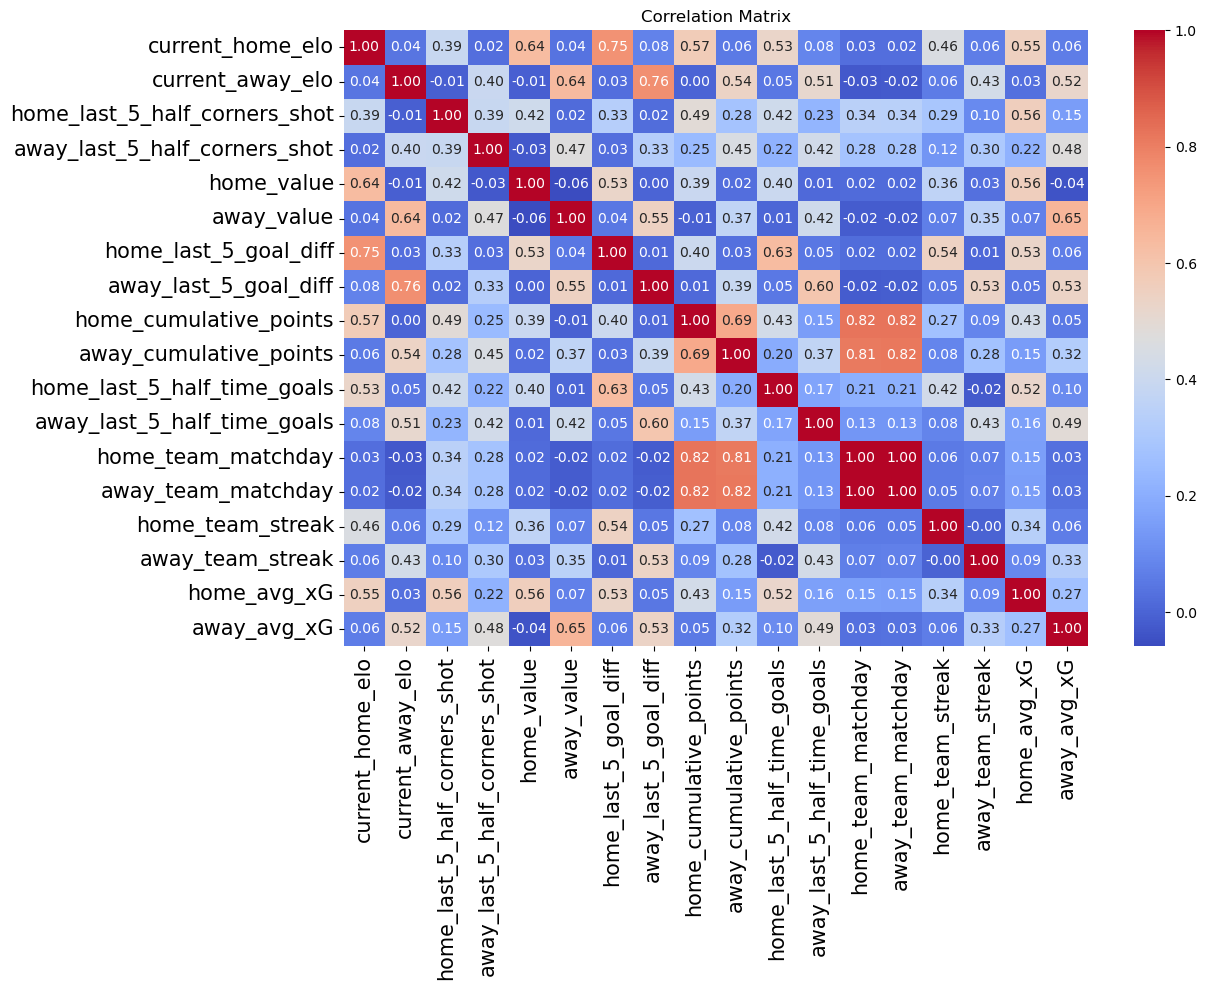

In [210]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)


  
plt.title("Correlation Matrix")
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)  
plt.show()


## Accuracy over Matchdays

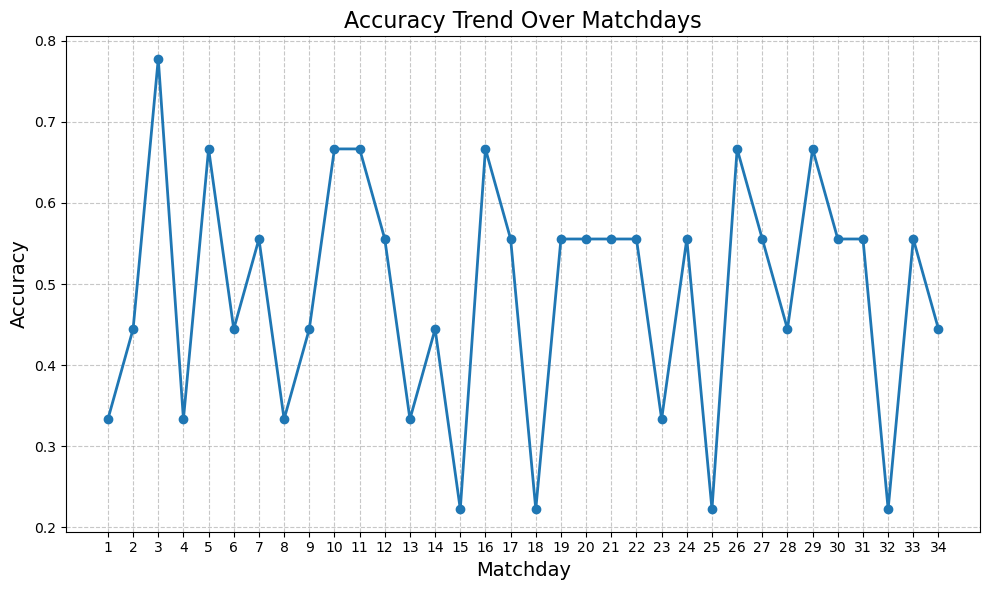

In [211]:
# Matchday axis (x-axis) and accuracy values (y-axis)
gamedays = list(range(1, len(accuracies) + 1))  # Matchdays (1, 2, ..., n)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(gamedays, accuracies, marker='o', linestyle='-', linewidth=2)

# Add labels to the plot
plt.title('Accuracy Trend Over Matchdays', fontsize=16)
plt.xlabel('Matchday', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(gamedays)  # Optional: Display each matchday as a tick
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

## Comparasion scaled vs unscaled data

In [212]:
df_scaled = pd.DataFrame(X_train, columns=list(X_train_box.columns))

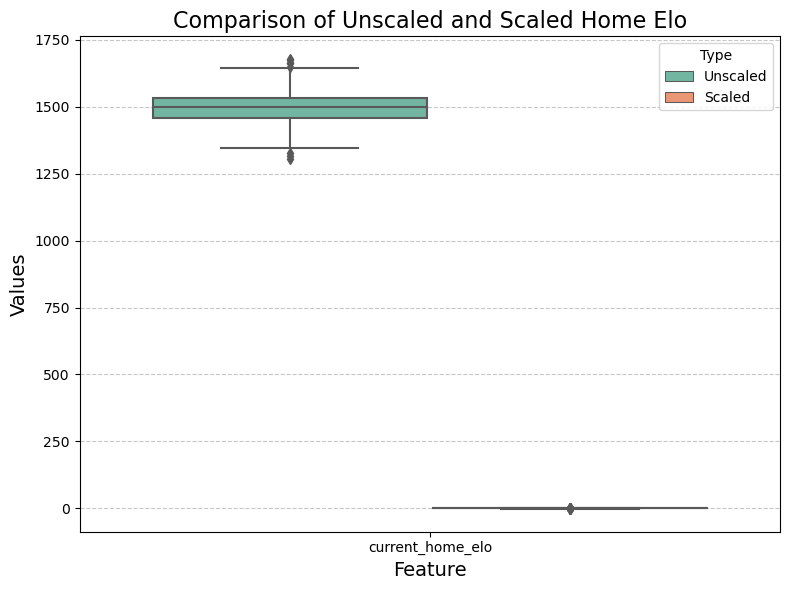

Values Range for 'current_home_elo':
Unscaled: Min = 1306.5308570332713, Max = 1679.0839174261605
Scaled: Min = -2.98, Max = 2.78


In [213]:

df_current_elo = X_train_box[['current_home_elo']]
df_scaled_current_elo = df_scaled[['current_home_elo']]
# Prepare data (Unscaled)
df_unscaled_melted = df_current_elo.melt(var_name='Feature', value_name='Value')
df_unscaled_melted['Type'] = 'Unscaled'

# Prepare data (Scaled)
df_scaled_melted = df_scaled_current_elo.melt(var_name='Feature', value_name='Value')
df_scaled_melted['Type'] = 'Scaled'

# Combine data
df_combined = pd.concat([df_unscaled_melted, df_scaled_melted])

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Feature', y='Value', hue='Type', data=df_combined, palette='Set2')
plt.title("Comparison of Unscaled and Scaled Home Elo", fontsize=16)
plt.ylabel("Values", fontsize=14)
plt.xlabel("Feature", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the results
print("Values Range for 'current_home_elo':")
print(f"Unscaled: Min = {df_current_elo['current_home_elo'].min()}, Max = {df_current_elo['current_home_elo'].max()}")
print(f"Scaled: Min = {df_scaled_current_elo['current_home_elo'].min():.2f}, Max = {df_scaled_current_elo['current_home_elo'].max():.2f}")